In [3]:
import pandas as pd
import seaborn as sb
import joblib
import numpy as np

from IPython.display import display
from IPython.display import display_html 


In [58]:
raw_data = joblib.load("../results/topmed.freeze1.1.dbvar.svafotate.jl")
raw_data['is_single'] = raw_data["AC"] == 1
raw_data['gnomad'] = raw_data["gnomAD_Count"] != 0
raw_data['1000g'] = raw_data["1000G_Count"] != 0
raw_data['ccdg'] = raw_data["CCDG_Count"] != 0
raw_data['is_known'] = raw_data['gnomad'] | raw_data['1000g'] | raw_data['ccdg']
raw_data['is_pass'] = raw_data['filter'].apply(lambda x: "PASS" in x)

data = raw_data[(raw_data['chrom'] != "chrX") & (raw_data['svlen'] >= 50)].copy()
all_known = data[data['is_pass']].groupby(['svtype', 'is_known']).size().unstack()
single_known = data[data['is_pass'] & data['is_single']].groupby(['svtype', 'is_known']).size().unstack()

all_known['known_pct'] = all_known[True] / all_known.sum(axis=1)
single_known['known_pct'] = single_known[True] / all_known.sum(axis=1)

# How many TopMed variants intersect with one of the other cohorts?

In [78]:
view = data[data['is_pass']]['is_known'].value_counts()
print(view[False] / view.sum())
print(view[True] / view.sum())
view

0.7200915789229017
0.2799084210770983


False    247844
True      96340
Name: is_known, dtype: int64

# Lets look at this by SVTYPE

In [30]:
all_known['novel_pct'] = 1 - all_known['known_pct']
all_known.loc[["DEL", "DUP", "INV"]]

is_known,False,True,known_pct,novel_pct
svtype,,,,
DEL,144408,78095,0.350984,0.649016
DUP,71666,16825,0.190132,0.809868
INV,31770,1420,0.042784,0.957216


# How many TopMed singletons (AC==1) are known?

In [33]:
single_known.loc[["DEL", "DUP", "INV"]]

is_known,False,True,known_pct
svtype,,,
DEL,84122,14094,0.063343
DUP,40931,3637,0.041100
INV,18720,276,0.008316


# Intersection per-anno source
How many topmed variants are found in the known annot sources using SVAFotate and min reciprocal overlap of 80

This is just a more detailed view of the above information

In [34]:
# intersection per-anno source
rows = []
srcs = ['gnomad', '1000g', 'ccdg', 'is_known']
for i in srcs:
    s = data[data['is_pass'] & (data[i] == True)]['svtype'].value_counts()
    s.name = i
    rows.append(s)
peranno = pd.concat(rows, axis=1).loc[["DEL", "DUP", "INV"]]
peranno.loc["Total"] = peranno.sum()
peranno

,gnomad,1000g,ccdg,is_known
DEL,52939,33844,42731,78095
DUP,10909,5312,7680,16825
INV,257,390,1248,1420
Total,64105,39546,51659,96340


In [35]:
peranno['is_known'] / len(data[data['is_pass']])

DEL      0.226899
DUP      0.048884
INV      0.004126
Total    0.279908
Name: is_known, dtype: float64

# And do it again for singletons

In [36]:
rows = []
for i in srcs:
    s = data[data['is_pass'] & (data[i] == True) & data['is_single']]['svtype'].value_counts()
    s.name = i
    rows.append(s)
peranno_single = pd.concat(rows, axis=1).loc[["DEL", "DUP", "INV"]]#, columns=["anno", "intersect"])
peranno_single.loc["Total"] = peranno_single.sum()
peranno_single

,gnomad,1000g,ccdg,is_known
DEL,7622,2188,7382,14094
DUP,1926,481,1762,3637
INV,57,56,216,276
Total,9605,2725,9360,18007


In [37]:
denom = len(data[data['is_pass'] & data['is_single']])
print("total number of singletons:", denom)
print("pct of all call", denom / data['is_pass'].sum())
peranno_single['is_known'] / denom

total number of singletons: 161780
pct of all call 0.4700392813146457


DEL      0.087118
DUP      0.022481
INV      0.001706
Total    0.111305
Name: is_known, dtype: float64

# And do it again for non-singletons

In [38]:
rows = []
srcs = ['gnomad', '1000g', 'ccdg', 'is_known']
for i in srcs:
    s = data[data['is_pass'] & (data[i] == True) & ~data['is_single']]['svtype'].value_counts()
    s.name = i
    rows.append(s)
peranno_nonsingle = pd.concat(rows, axis=1).loc[["DEL", "DUP", "INV"]]
peranno_nonsingle.loc["Total"] = peranno_nonsingle.sum()
peranno_nonsingle

,gnomad,1000g,ccdg,is_known
DEL,45317,31656,35349,64001
DUP,8983,4831,5918,13188
INV,200,334,1032,1144
Total,54500,36821,42299,78333


In [39]:
denom = len(data[data['is_pass'] & ~data['is_single']])
print("total number of non singletons:", denom)
print("pct of all call", denom / data['is_pass'].sum())
peranno_nonsingle['is_known'] / denom

total number of non singletons: 182404
pct of all call 0.5299607186853543


DEL      0.350875
DUP      0.072301
INV      0.006272
Total    0.429448
Name: is_known, dtype: float64

## Interesting observation:

Even though we make more variant calls (376K compared to 2nd largest gnomad at 219K), our number of single sample calls found in other cohorts aren't proportionally larger than others. For example, 2284 of our single sample DELs intersect with any other cohort while 2014 of gnomAD's single sample DELs intersect with any other cohort.

These numbers are 410 TopMed / 435 gnomAD for Duplications and 15 TopMed /16 gnomAD for Inversions.

So TopMed has ~1.5x more variants, but approximately equal counts of single sample calls shared across cohorts.

In [40]:
# Official figure
everyone = joblib.load("../topmed_known_svafotate/biginter_all.autosome.jl")
single = joblib.load("../topmed_known_svafotate/biginter_single.autosome.jl")
nonsingle = joblib.load("../topmed_known_svafotate/biginter_nonsingle.autosome.jl")

In [41]:
# How many of a_src overlap b_src as a percent.
index = ["1000G", "CCDG", "gnomAD", "TopMed"]

def make_pct(dat, row, col):
    if row == col:
        return np.nan
    j = dat[(dat["a_src"] == row) & (dat["b_src"] == col)].sum(axis=0)
    if j['ab_ovl'] != 0:
        pct = j['ab_ovl'] / j['a_cnt']
    else:
        pct = 0
    return pct

a_matrix = []
s_matrix = []
ns_matrix = []
for row in index:
    cur_a_row = []
    cur_s_row = []
    cur_ns_row = []
    for col in index:
        cur_a_row.append(make_pct(everyone, row, col))
        cur_s_row.append(make_pct(single, row, col))
        cur_ns_row.append(make_pct(nonsingle, row, col))
    a_matrix.append(cur_a_row)
    s_matrix.append(cur_s_row)
    ns_matrix.append(cur_ns_row)
a_matrix = pd.DataFrame(a_matrix, index=index, columns=index)
s_matrix = pd.DataFrame(s_matrix, index=index, columns=index)
ns_matrix = pd.DataFrame(ns_matrix, index=index, columns=index)

In [42]:
# What percent of ROW cohorts intersect with a COL call (of same type and 80% reciprocal overlap).
(a_matrix * 100).round(1)

,1000G,CCDG,gnomAD,TopMed
1000G,NaN,20.4,38.4,28.0
CCDG,14.9,NaN,24.2,27.7
gnomAD,20.4,17.9,NaN,25.5
TopMed,11.1,14.5,17.9,NaN


In [43]:
# What percent of ROW cohorts' singletons intersect with a COL call (of same type and 80% reciprocal overlap).
(s_matrix *  100).round(1)

,1000G,CCDG,gnomAD,TopMed
1000G,NaN,13.8,20.8,15.9
CCDG,0.0,NaN,0.0,0.0
gnomAD,5.7,14.2,NaN,22.1
TopMed,2.3,6.4,6.8,NaN


In [44]:
# What percent of ROW cohorts' non-singletons intersect with a COL call (of same type and 80% reciprocal overlap).
(ns_matrix *  100).round(1)

,1000G,CCDG,gnomAD,TopMed
1000G,NaN,21.0,40.2,29.2
CCDG,14.9,NaN,24.2,27.7
gnomAD,22.4,18.4,NaN,26.0
TopMed,12.2,15.5,19.4,NaN


In [68]:
everyone['Subset'] = 'all'
single['Subset'] = 'singleton'
nonsingle['Subset'] = 'nonsingleton'
sup_table = pd.concat([everyone, single, nonsingle])

In [71]:
sup_table[['Subset', 'a_src', 'b_src', 'svtype', 'a_cnt', 'b_cnt', 'ab_ovl']].to_csv("suptable_known.tsv", sep='\t', index=False)

# Allele frequency correlations

In [45]:
data['TopMed_AF'] = data['AF'].apply(lambda x: x[0])
view = data[data['is_pass']]

In [46]:
from scipy.stats import pearsonr

max_af = view[view['is_known']][['TopMed_AF', 'Max_AF', 'svtype']]
one_af = view[view['1000g']][['TopMed_AF', 'Best_1000G_AF', 'svtype']]
cdg_af = view[view['ccdg']][['TopMed_AF', 'Best_CCDG_AF', 'svtype' ]]
gno_af = view[view['gnomad']][['TopMed_AF', 'Best_gnomAD_AF', 'svtype']]
for i,j in [("Max", max_af), ("1000G", one_af), ("CCDG", cdg_af), ("gnomAD", gno_af)]:
    t, o = j.values[:, 0], j.values[:, 1]
    print(i, pearsonr(t, o))

Max PearsonRResult(statistic=0.9413672581180348, pvalue=0.0)
1000G PearsonRResult(statistic=0.9773465959006792, pvalue=0.0)
CCDG PearsonRResult(statistic=0.972439110832589, pvalue=0.0)
gnomAD PearsonRResult(statistic=0.9555505862930398, pvalue=0.0)


In [47]:
from scipy.stats import pearsonr
view = view.copy()

max_af = view[view['is_known']][['TopMed_AF', 'Max_AF', 'svtype']]
one_af = view[view['1000g']][['TopMed_AF', 'Best_1000G_AF', 'svtype']]
cdg_af = view[view['ccdg']][['TopMed_AF', 'Best_CCDG_AF', 'svtype' ]]
gno_af = view[view['gnomad']][['TopMed_AF', 'Best_gnomAD_AF', 'svtype']]
for i,j in [("Max", max_af), ("1000G", one_af), ("CCDG", cdg_af), ("gnomAD", gno_af)]:
    t, o = j.values[:, 0], j.values[:, 1]
    print(i, pearsonr(t, o))
    
print()

for svtype in ["DEL", "DUP", "INV"]:
    for i,j in [("Max", max_af), ("1000G", one_af), ("CCDG", cdg_af), ("gnomAD", gno_af)]:
        j = j[j['svtype'] == svtype]
        t, o = j.values[:, 0], j.values[:, 1]
        print(svtype, i, len(t), pearsonr(t, o))

Max PearsonRResult(statistic=0.9413672581180348, pvalue=0.0)
1000G PearsonRResult(statistic=0.9773465959006792, pvalue=0.0)
CCDG PearsonRResult(statistic=0.972439110832589, pvalue=0.0)
gnomAD PearsonRResult(statistic=0.9555505862930398, pvalue=0.0)

DEL Max 78095 PearsonRResult(statistic=0.9583280299864165, pvalue=0.0)
DEL 1000G 33844 PearsonRResult(statistic=0.9808436244133192, pvalue=0.0)
DEL CCDG 42731 PearsonRResult(statistic=0.9931218752767672, pvalue=0.0)
DEL gnomAD 52939 PearsonRResult(statistic=0.9575476561099253, pvalue=0.0)
DUP Max 16825 PearsonRResult(statistic=0.9175742162944212, pvalue=0.0)
DUP 1000G 5312 PearsonRResult(statistic=0.9676066786537405, pvalue=0.0)
DUP CCDG 7680 PearsonRResult(statistic=0.955672298559451, pvalue=0.0)
DUP gnomAD 10909 PearsonRResult(statistic=0.8894289344308475, pvalue=0.0)
INV Max 1420 PearsonRResult(statistic=0.4110426953098546, pvalue=5.297119832173192e-59)
INV 1000G 390 PearsonRResult(statistic=0.5164938483998082, pvalue=5.600743915584112e-

In [83]:
inv = data[data['is_pass'] & (data['svtype'] == 'INV')]
for i in ['is_known', '1000g', 'ccdg', 'gnomad']:
    print(i)
    print(inv[i].value_counts())

is_known
False    31770
True      1420
Name: is_known, dtype: int64
1000g
False    32800
True       390
Name: 1000g, dtype: int64
ccdg
False    31942
True      1248
Name: ccdg, dtype: int64
gnomad
False    32933
True       257
Name: gnomad, dtype: int64


1. Make 0.005 width bins for the TopMed AFs (x).
2. Groupby SVTYPE (including all) and these bins
3. For the max and each cohort, get the Best_*_AF mean (y).

end with:
AF_Bin, svtype, other cohort name, AF

I was trying to visualize the AF correlations, but it just doesn't convey anything more useful than the pearsonr coeff. Abandoning this as a fig3b replacement.

In [48]:
view = data[data['is_pass']].copy()
m_bins = []
cur = 0
while cur <= 1.005:
    m_bins.append(cur)
    cur += 0.005
view["TopMed_AFbin"] = pd.cut(view["TopMed_AF"], bins=m_bins)

In [49]:
rows = []
#for i, d in view.groupby(['svtype', 'TopMed_AFbin']):
for i, d in view.groupby('TopMed_AFbin'):
    for okey, ocol, oname in [('is_known', "Max_AF", 'Max'), ('1000g', "Best_1000G_AF", "1KGP"),
                              ("ccdg", "Best_CCDG_AF", "CCDG"), ("gnomad", "Best_gnomAD_AF", "gnomAD")]:
        m_af = d[d[okey]][ocol].mean()
        rows.append([i, oname, m_af])
fig3 = pd.DataFrame(rows, columns=["AFbin", "Cohort", "MeanAF"]) 


In [50]:
fig3 = fig3.sort_values(by="AFbin")
fig3["AFbin"] = fig3["AFbin"].astype(str)

<Axes: xlabel='AFbin', ylabel='MeanAF'>

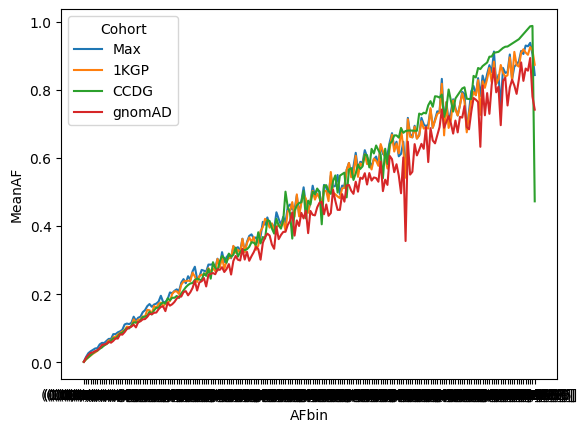

In [51]:
sb.lineplot(data=fig3, x="AFbin", y="MeanAF", hue="Cohort")

# Figure 3b

In [52]:
view = data[data['is_pass'] & ~data['is_single']]
kno = view[view["is_known"]]["TopMed_AF"].copy().to_frame()
gno = view[view["gnomad"]]["TopMed_AF"].copy().to_frame()
one = view[view["1000g"]]["TopMed_AF"].copy().to_frame()
cdg = view[view["ccdg"]]["TopMed_AF"].copy().to_frame()
new = view[~view["is_known"]]["TopMed_AF"].copy().to_frame()

In [53]:
kno["intersection"] = "Any"
gno["intersection"] = "gnomAD"
one["intersection"] = "1KGP"
cdg["intersection"] = "CCDG"
new["intersection"] = "Unique"
view = pd.concat([kno, gno, cdg, one, new])

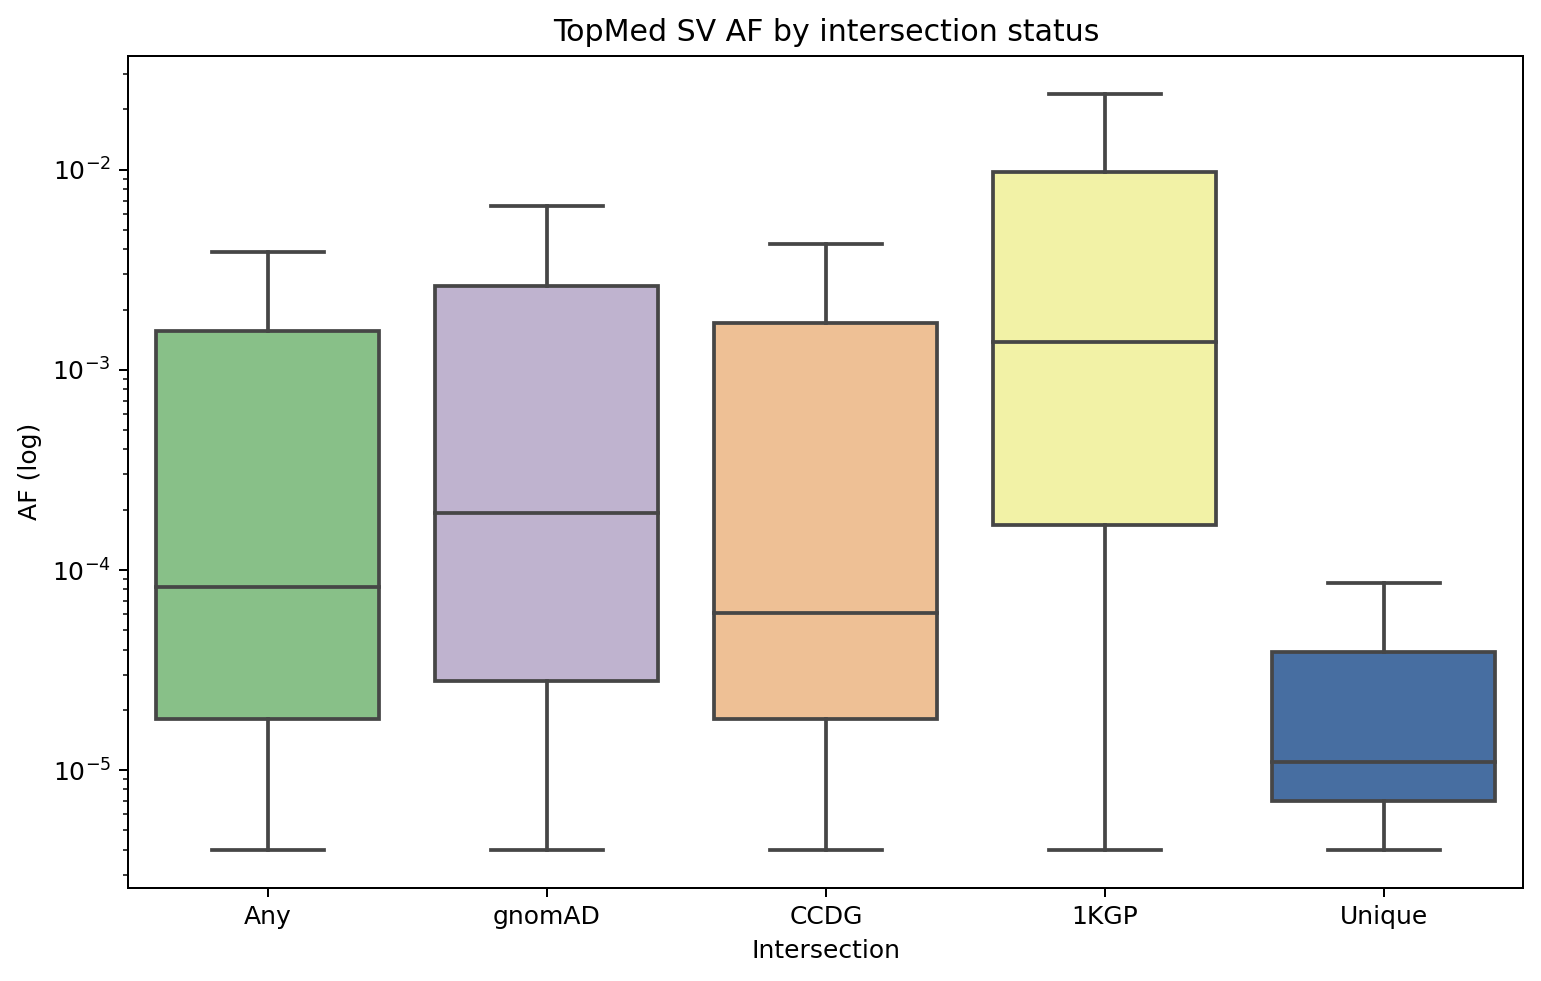

In [55]:
import matplotlib.pyplot as plt
#sb.set(rc={'figure.figsize':(15.7,8.27)})
#sb.reset_orig()
plt.figure(dpi=180, figsize=(10,6))
p = sb.boxplot(data=view, x="intersection", y="TopMed_AF", palette=sb.color_palette("Accent"), showfliers=False)
p.set(yscale='log', ylabel="AF (log)", xlabel="Intersection", title="TopMed SV AF by intersection status")
plt.show()

In [56]:
view["intersection"].value_counts()

Unique    104071
Any        78333
gnomAD     54500
CCDG       42299
1KGP       36821
Name: intersection, dtype: int64

# chrX novel by sex

Have to address that with `../results/gender_data.txt.gz` - deciphering if unique to a sex - joining that status to data - then grouping/counting/printing the table.

In [59]:
gender = pd.read_csv("../results/gender_data.txt.gz", sep='\t', header=None, 
                     names=["id", "f_ref", "f_het", "f_alt", "m_ref", "m_alt"])
gender.set_index("id", inplace=True)

gdata = raw_data[raw_data['is_pass']].set_index('id').join(gender)

In [60]:
gdata['in_male'] = gdata['m_alt'] != 0
gdata['in_female'] = (gdata['f_het'] + gdata['f_alt']) != 0
m_exclusive = gdata[gdata['in_male'] & ~gdata['in_female']]
f_exclusive = gdata[~gdata['in_male'] & gdata['in_female']]

In [61]:
len(m_exclusive), len(f_exclusive)

(2973, 8956)

In [63]:
v = m_exclusive.groupby(['svtype', 'is_known']).size().unstack().loc[["DEL", "DUP", "INV"]]
v.columns = ["novel", "known"]
v['TOT'] = v.sum(axis=1)
v.loc['TOT'] = v.sum(axis=0)
v

,novel,known,TOT
svtype,,,
DEL,1247,134,1381
DUP,946,105,1051
INV,522,19,541
TOT,2715,258,2973


In [64]:
v = f_exclusive.groupby(['svtype', 'is_known']).size().unstack().loc[["DEL", "DUP", "INV"]]
v.columns = ["novel", "known"]
v['TOT'] = v.sum(axis=1)
v.loc['TOT'] = v.sum(axis=0)
v

,novel,known,TOT
svtype,,,
DEL,3898,363,4261
DUP,3073,285,3358
INV,1319,18,1337
TOT,8290,666,8956


In [65]:
data['is_pass'].sum()

344184

In [66]:
data[data['chrom'] != 'chrX']['is_pass'].sum()

344184